In [34]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [36]:
# nltk 다운로드 필요
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# 데이터 로드
file_path = './wine_review.csv'
df = pd.read_csv(file_path)

# 데이터 구조 확인
# print(df.head())
# print(df.info())

# 결측값 처리: 리뷰 텍스트와 레이팅이 없는 행 제거
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# 불필요한 열 제거
columns_to_drop = ['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 
                   'descriptions', 'dimension', 'ean', 'flavors', 'keys', 
                   'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 
                   'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 
                   'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 
                   'reviews.sourceURLs', 'reviews.userCity', 
                   'reviews.userProvince', 'reviews.username', 'sizes', 
                   'sourceURLs', 'upc', 'weight']
df = df.drop(columns=columns_to_drop)

# reviews.text와 reviews.title을 합쳐서 reviews 열 생성
df['reviews'] = df['reviews.text'].fillna('') + ' ' + df['reviews.title'].fillna('')

# 기존의 reviews.text와 reviews.title 열 삭제
df.drop(columns=['reviews.text', 'reviews.title'], inplace=True)

# 데이터 구조 확인
# print(df.head())
# print(df.info())

# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # 구두점 제거
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 숫자 제거
    text = re.sub(r'\d+', '', text)
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    # 어간 추출 (또는 표제어 추출 사용 가능)
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# 리뷰 텍스트 전처리 적용
df['cleaned_reviews'] = df['reviews'].apply(preprocess_text)

# reviews.rating이 3.0인 행만 남기고 제거
df = df[df['reviews.rating'] != 3.0]

# 평점이 3이 아닌 행만 저장하여 csv파일 생성
# print(df.head())
# df.to_csv(r"./rating_is_not_3_filtered.csv", index = False)

# 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여, 부여된 레이블은 새로 생성한 label이라는 열에 저장
df['label'] = np.where(df['reviews.rating'] > 3, 1, 0)

# 최종 데이터 생성
df.to_csv(r"./wine_review_filtered.csv", index = False)





[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# 전처리된 데이터 불러오기
df = pd.read_csv('./wine_review_filtered.csv')

# 특성과 레이블 분리하기
X = df['cleaned_reviews']
y = df['label']

# 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화를 사용하여 텍스트 데이터 변환하기
vectorizer = TfidfVectorizer(max_features=5000)  # 필요에 따라 max_features 조정 가능
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# SVM 분류기 초기화
svm_classifier = SVC(kernel='linear')

# SVM 모델 학습하기
svm_classifier.fit(X_train_vectorized, y_train)

# 테스트 데이터 예측하기
y_pred = svm_classifier.predict(X_test_vectorized)

# 모델 평가하기
accuracy = accuracy_score(y_test, y_pred)
print(f'정확도: {accuracy:.2f}')

# 분류 보고서 출력하기
print(classification_report(y_test, y_pred))


정확도: 0.96
              precision    recall  f1-score   support

           0       1.00      0.09      0.16        23
           1       0.96      1.00      0.98       453

    accuracy                           0.96       476
   macro avg       0.98      0.54      0.57       476
weighted avg       0.96      0.96      0.94       476



Mean Squared Error (MSE): 0.54
R-squared (R2) score: 0.19


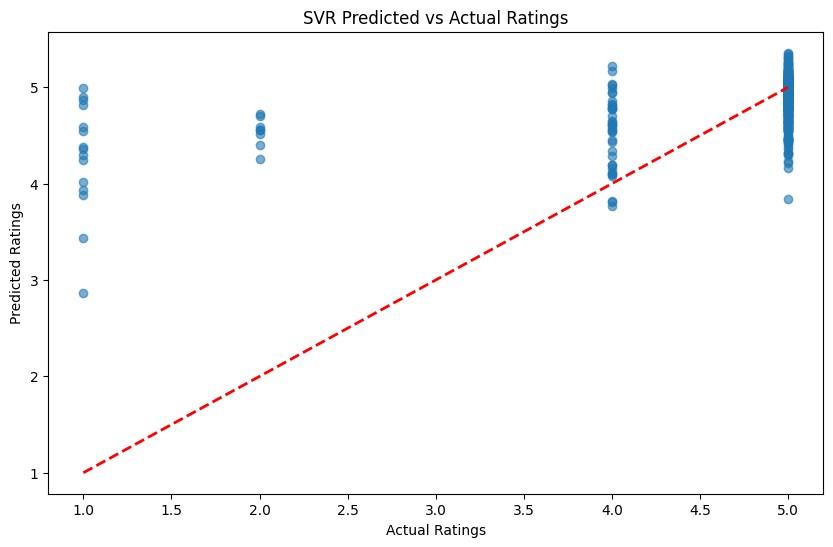

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 전처리된 데이터 불러오기
df = pd.read_csv('./wine_review_filtered.csv')

# 특성과 레이블 분리하기
X = df['cleaned_reviews']
y = df['reviews.rating']  # 레이블은 회귀이므로 원래 평점으로

# 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화를 사용하여 텍스트 데이터 변환하기
vectorizer = TfidfVectorizer(max_features=5000)  # 필요에 따라 max_features 조정 가능
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# SVR 모델 초기화
svr_model = SVR(kernel='linear')  # 선형 커널 사용 (다른 커널도 실험 가능: 'rbf', 'poly', etc.)

# SVR 모델 학습하기
svr_model.fit(X_train_vectorized, y_train)

# 테스트 데이터에 대한 예측값 생성
y_pred = svr_model.predict(X_test_vectorized)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2) score: {r2:.2f}')

# 예측 결과와 실제 값을 비교하는 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('SVR Predicted vs Actual Ratings')
plt.show()
